<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v7: Productionising Gradient capturing and visualisation
This notebook carries on from v4 with work to productionise the capture and display of gradient information.

However it takes a more cautious small-step approach:
* Uses a custom-training loop instead of trying to wrap an optimizer (later experience has shown that the optimizer wrapping needs some more work to be compatible with the later versions of Keras)
* Doesn't try to work out gradient sign changes, just the raw gradients.
* Supports some more variations of model architecture.
* Tries to be as close to plug'n'play as possible.

In [69]:
# Clone repo and load its modules

import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
!cd repo && git pull

import sys
sys.path.append('repo')

import toolkit
from importlib import reload
reload(toolkit)

Cloning into 'repo'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 121 (delta 59), reused 22 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 12.90 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Already up to date.


<module 'toolkit' from '/content/repo/toolkit.py'>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit

In [66]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

## Baseline

In [4]:
def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


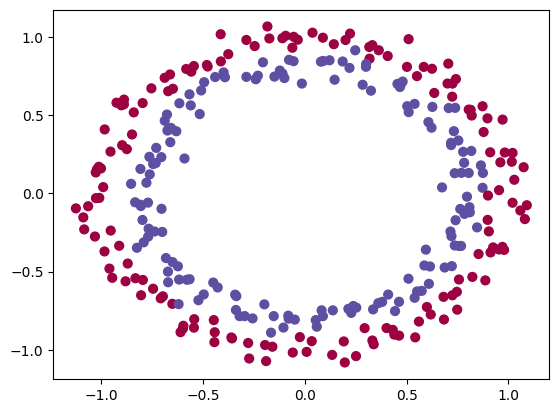

In [5]:
def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

Epoch    50 - 0.0s: loss: 0.6613  
Epoch   100 - 0.0s: loss: 0.3178  
Epoch   150 - 0.0s: loss: 0.0514  
Epoch   200 - 0.0s: loss: 0.0190  
Epoch   250 - 0.1s: loss: 0.0100  
Epoch   300 - 0.0s: loss: 0.0059  
Epoch   350 - 0.0s: loss: 0.0038  
Epoch   400 - 0.0s: loss: 0.0026  
Epoch   450 - 0.0s: loss: 0.0019  
Epoch   500 - 0.0s: loss: 0.0015  
Total training time: 16.25 secs


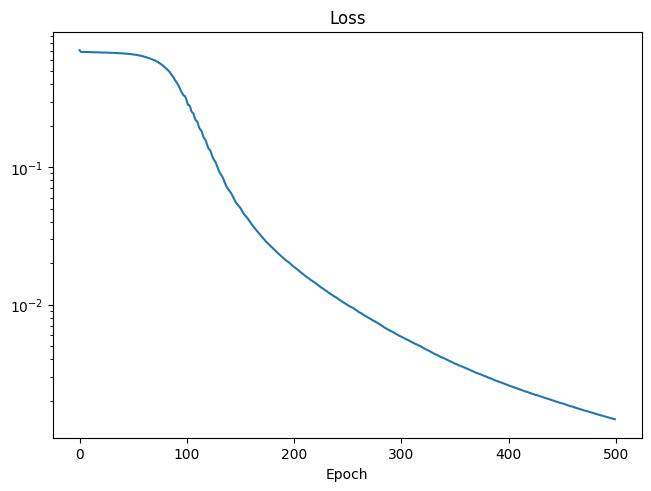

In [41]:
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=500, batch_size=train_X.shape[0], verbose=0, callbacks=[toolkit.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

In [18]:
model.loss

'binary_crossentropy'

In [19]:
model.metrics

[<Mean name=loss>]

## Custom training loop

Execution mode: autograph
Epoch    50 - 111.68ms/epoch: loss: 0.6623  mse: 0.2349  
Epoch   100 - 9.90ms/epoch: loss: 0.3049  mse: 0.0779  
Epoch   150 - 14.85ms/epoch: loss: 0.0663  mse: 0.0115  
Epoch   200 - 7.47ms/epoch: loss: 0.0264  mse: 0.0039  
Epoch   250 - 8.01ms/epoch: loss: 0.0135  mse: 0.0014  
Epoch   300 - 7.98ms/epoch: loss: 0.0080  mse: 0.0007  
Epoch   350 - 7.88ms/epoch: loss: 0.0050  mse: 0.0003  
Epoch   400 - 7.61ms/epoch: loss: 0.0035  mse: 0.0002  
Epoch   450 - 9.44ms/epoch: loss: 0.0025  mse: 0.0001  
Epoch   500 - 8.29ms/epoch: loss: 0.0018  mse: 0.0001  
Total training time: 9.60 secs


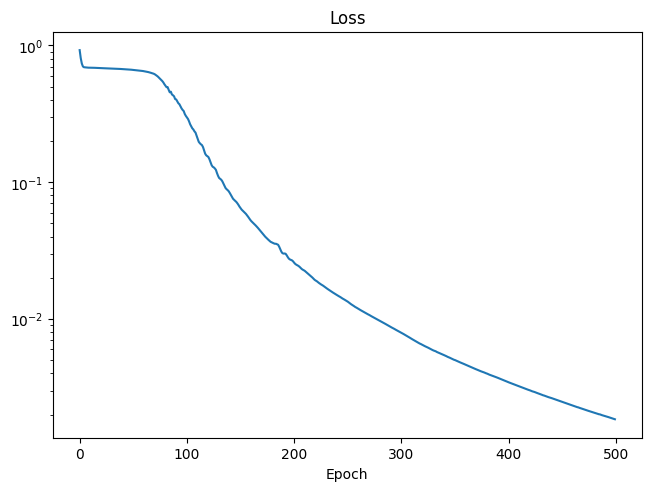

In [72]:
import keras  ##keras.utils.unpack_x_y_sample_weight

class GradientCallback:
    def __init__(self):
        self.params = None
        self._model = None

    def set_params(self, params):
        self.params = params

    def set_model(self, model):
        self._model = model

    @property
    def model(self):
        return self._model

    def on_train_begin(self):
        """Called at the beginning of training.

        Subclasses should override for any actions to run.
        """

    def on_train_end(self):
        """Called at the end of training.

        Subclasses should override for any actions to run.
        """

    def on_epoch_begin(self, epoch):
        """Called at the start of an epoch.

        Subclasses should override for any actions to run.

        Args:
            epoch: Integer, index of epoch.
        """

    def on_epoch_end(self, epoch, loss, gradients, trainable_variables, activations=None):
        """Called at the end of an epoch during training.
        Subclasses should override for any actions to run.

        Supplied with training parameters from the last batch of the epoch.
        Can be a convenient alternative where training doesn't use batches,
        or when you only want to sample the occasional update.

        Args:
            epoch: Integer, index of epoch.
            loss: float. The loss value of the batch.
            gradients: the list of gradients for each trainable variable.
            trainable_variables: the list of trainable variables.
            activations: the list of activations for each layer. Currently
              never populated, but might be in the future.
        """

    def on_train_batch_begin(self, batch):
        """Called at the beginning of a training batch in `fit` methods.

        Subclasses should override for any actions to run.

        Note that if the `steps_per_execution` argument to `compile` in
        `Model` is set to `N`, this method will only be called every
        `N` batches.

        Args:
            batch: Integer, index of batch within the current epoch.
        """

    def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations=None):
        """Called at the end of a training batch in `fit` methods.

        Subclasses should override for any actions to run.

        Note that if the `steps_per_execution` argument to `compile` in
        `Model` is set to `N`, this method will only be called every
        `N` batches.

        Args:
            batch: Integer, index of batch within the current epoch.
            loss: float. The loss value of the batch.
            gradients: the list of gradients for each trainable variable.
            trainable_variables: the list of trainable variables.
            activations: the list of activations for each layer. Currently
              never populated, but might be in the future.
        """


def train_step(model, x_batch_train, y_batch_train, sample_weight):
    reported_loss = None

    # Forward pass
    with tf.GradientTape() as tape:
      y_batch_pred = model(x_batch_train)
      loss = model.compute_loss(x=x_batch_train, y=y_batch_train, y_pred=y_batch_pred, sample_weight=sample_weight, training=True)
      reported_loss = loss  # tracking before scaling
      loss = model.optimizer.scale_loss(loss)

    # Backward pass
    if model.trainable_weights:
      gradients = tape.gradient(loss, model.trainable_variables)

      model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    else:
      raise ValueError('No trainable weights to update.')

    # Metrics
    metrics = model.compute_metrics(x=x_batch_train, y=y_batch_train, y_pred=y_batch_pred, sample_weight=sample_weight)

    return reported_loss, metrics, gradients

# Honours tf.config.run_functions_eagerly(bool)
# See tensorflow trainer.Trainer.train_step() for reference
def fit(model, dataset, epochs=1, verbose=1, callbacks=None, initial_epoch=0, gradient_callback=None):

  # prepare epochs
  num_batches=len(dataset)

  # prepare callbacks tracking
  if not isinstance(callbacks, tf.keras.callbacks.CallbackList):
    callbacks = tf.keras.callbacks.CallbackList(callbacks, add_history=True, add_progbar=verbose != 0, verbose=verbose, epochs=epochs, steps=num_batches, model=model)
  if gradient_callback is None:
    gradient_callback = GradientCallback()
  gradient_callback.set_params({'epochs': epochs, 'steps': len(dataset)})
  gradient_callback.set_model(model)

  # prepare train function
  if tf.config.functions_run_eagerly():
    print(f"Execution mode: eager")
    train_step_fn = train_step
  else:
    print(f"Execution mode: autograph")
    train_step_fn = tf.function(train_step)

  # train
  logs = {}  # holds latest value at any given moment in time
  callbacks.on_train_begin()
  gradient_callback.on_train_begin()
  for epoch in range(initial_epoch, epochs):
    model.reset_metrics()
    start = tf.timestamp()
    callbacks.on_epoch_begin(epoch)
    gradient_callback.on_epoch_begin(epoch)

    for step, (x_batch_train, y_batch_train) in enumerate(dataset):
      sample_weight = None  # TODO use: x, y, sample_weight = data_adapter_utils.unpack_x_y_sample_weight(data)
      #print(f"  Step {step+1}: x_batch_train: {x_batch_train.shape}, y_batch_train: {y_batch_train.shape}")
      callbacks.on_train_batch_begin(step)
      gradient_callback.on_train_batch_begin(step)

      loss, metrics, gradients = train_step_fn(model, x_batch_train, y_batch_train, sample_weight)

      logs = metrics
      logs['loss'] = loss.numpy()
      callbacks.on_train_batch_end(step, logs)
      gradient_callback.on_train_batch_end(step, loss, gradients, model.trainable_variables, None)

    # end of epoch
    dur = (tf.timestamp() - start).numpy()
    callbacks.on_epoch_end(epoch, logs) # should be passing loss and mse
    gradient_callback.on_epoch_end(epoch, loss, gradients, model.trainable_variables, None)
    metric_str = ''
    for k in logs.keys():
      metric_str += f" - {k}: {logs[k]:.3f}"
  callbacks.on_train_end(logs)
  gradient_callback.on_train_end()

  return model.history

tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
#history = model.fit(train_X, train_Y, epochs=500, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(train_X.shape[0])
history = fit(model, dataset, epochs=500, verbose=0, callbacks=[toolkit.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

## Capturing gradients


In [14]:
import keras  ##keras.utils.unpack_x_y_sample_weight



def train_step(model, x_batch_train, y_batch_train, sample_weight):
    reported_loss = None

    # Forward pass
    with tf.GradientTape() as tape:
      y_batch_pred = model(x_batch_train)
      loss = model.compute_loss(x=x_batch_train, y=y_batch_train, y_pred=y_batch_pred, sample_weight=sample_weight, training=True)
      reported_loss = loss  # tracking before scaling
      loss = model.optimizer.scale_loss(loss)

    # Backward pass
    if model.trainable_weights:
      gradients = tape.gradient(loss, model.trainable_variables)

      model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    else:
      raise ValueError('No trainable weights to update.')

    # Metrics
    metrics = model.compute_metrics(x=x_batch_train, y=y_batch_train, y_pred=y_batch_pred, sample_weight=sample_weight)

    return reported_loss, metrics, gradients

# Honours tf.config.run_functions_eagerly(bool)
# See tensorflow trainer.Trainer.train_step() for reference
def fit(model, dataset, epochs=1, verbose=1, callbacks=None, initial_epoch=0):

  # prepare epochs
  num_batches=len(dataset)

  # prepare callbacks tracking
  if not isinstance(callbacks, tf.keras.callbacks.CallbackList):
    callbacks = tf.keras.callbacks.CallbackList(callbacks, add_history=True, add_progbar=verbose != 0, verbose=verbose, epochs=epochs, steps=num_batches, model=model)

  # prepare train function
  if tf.config.functions_run_eagerly():
    print(f"Execution mode: eager")
    train_step_fn = train_step
  else:
    print(f"Execution mode: autograph")
    train_step_fn = tf.function(train_step)

  # train
  #gradients_list = []
  logs = {}  # holds latest value at any given moment in time
  callbacks.on_train_begin()
  for epoch in range(initial_epoch, epochs):
    model.reset_metrics()
    start = tf.timestamp()
    callbacks.on_epoch_begin(epoch)

    for step, (x_batch_train, y_batch_train) in enumerate(dataset):
      sample_weight = None  # TODO use: x, y, sample_weight = data_adapter_utils.unpack_x_y_sample_weight(data)
      #print(f"  Step {step+1}: x_batch_train: {x_batch_train.shape}, y_batch_train: {y_batch_train.shape}")
      callbacks.on_train_batch_begin(step)

      loss, metrics, gradients = train_step_fn(model, x_batch_train, y_batch_train, sample_weight)

      #gradients_list.append(gradients)
      logs = metrics
      logs['loss'] = loss.numpy()
      callbacks.on_train_batch_end(step, logs)

    # end of epoch
    dur = (tf.timestamp() - start).numpy()
    callbacks.on_epoch_end(epoch, logs) # should be passing loss and mse
    metric_str = ''
    for k in logs.keys():
      metric_str += f" - {k}: {logs[k]:.3f}"
    #print(f"Epoch {epoch+1} - {dur:.1f}s - loss: {logs['loss']:.3f}{metric_str}")
  callbacks.on_train_end(logs)

  #return history, gradients_list
  return model.history

tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
#history = model.fit(train_X, train_Y, epochs=500, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(train_X.shape[0])
history = fit(model, dataset, epochs=500, verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

In [15]:
model.losses

[]